## Zadanie - klasyczna detekcja obiektów

Celem tego zadania jest własnoręczne zbudowanie, debugowanie i przetestowanie przez Ciebie prostego pipeline'u do rozpoznawania obiektów opartego o klasyczne metody przetwarzania obrazów.

In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

from enum import Enum
from typing import Any, List

Dany jest obraz wzorcowy `calib` przedstawiający leki w organizerze.
Twoim zadaniem będzie zaproponowanie algorytmu detekcji, który przyjmie obraz wejściowy i wykryje na nim obiekty - poszczególne tabletki, zwracając informację o ich położeniach i gatunkach.
Reprezentacja tej informacji jest dowolna: pary koordynat (X,Y) środka obiektu, bounding boksy (XYHW), czy kontury - istotne jest jedynie, by liczba detekcji możliwie dobrze zgadzała się ze stanem faktycznym.

Zadanie ma charakter projektowy i nie jest podzielone na szczegółowo opisane podpunkty, ponieważ można do niego podejść na różne sposoby (czytaj dalej).

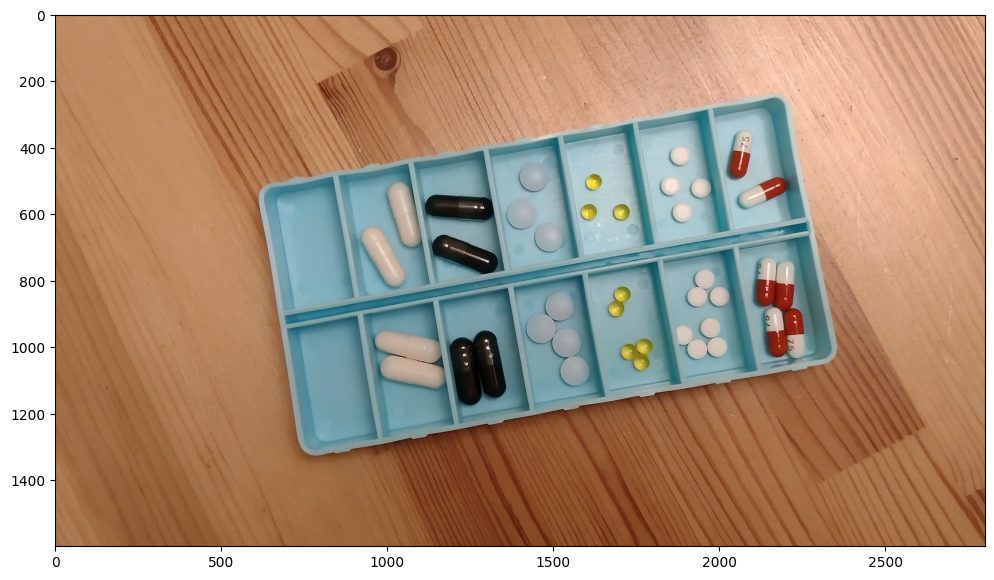

In [2]:
calib = cv2.imread('Lab5_dane/calib.png')[..., ::-1]
test = cv2.imread('Lab5_dane/test.png')[..., ::-1]
line = cv2.imread('Lab5_dane/test_line.png')[..., ::-1]
plt.subplots(1, 1, figsize=(12,8))[1].imshow(calib);

Występuje 6 klas obiektów; patrząc na organizer od lewej:

In [3]:
class PillType(Enum):
    PROBIO = 1    # duże białe kapsułki
    CARBON = 2    # duże czarne kapsułki
    KETO = 3      # niebieskie tabletki
    ESPU = 4      # małe żółte kapsułki
    BIOX = 5      # małe białe tabletki
    LINE = 6      # czerwono-białe kapsułki (klasa trudna - realizacja opcjonalna)

Górny rząd zawiera łatwiejsze przykłady pojedynczych instancji, podczas gdy w rzędzie dolnym obiekty stykają się ze sobą, co utrudnia identyfikację.
Jak widzisz, nie wszystkie klasy są tak samo "wdzięczne" do wykrycia.
Nie próbuj zatem robić wszystkiego naraz - rekomendowane jest podejście sekwencyjne: najpierw zaimplementuj algorytm detekcji dla jednej klasy, przetestuj go i napraw, rozszerz o możliwość detekcji stykających się obiektów (_jak to zrobić?_), a dopiero potem podejmij kolejną klasę.

Wykorzystaj narzędzia poznane do tej pory (konwersje przestrzeni barw, binaryzację, detekcję krawędzi, etc.) by sprowadzić obraz do takiej postaci, w której detekcję interesujących obiektów będzie można wykonać za pomocą zwyczajnej ekstrakcji komponentów spójności - [`cv2.findContours`](https://docs.opencv.org/4.x/d3/dc0/group__imgproc__shape.html#gadf1ad6a0b82947fa1fe3c3d497f260e0).
Wspomóż się operacjami morfologicznymi jeśli to potrzebne, i nie wahaj się stosować jakichkolwiek narzędzi jakie znajdziesz -
wszystkie chwyty są dozwolone, za wyjątkiem stosowania metod MLowych.

W zależności od wybranej reprezentacji wykrytych obiektów, zaimplementuj metodę wizualizacji wyników.

Nie usuwaj notebooka, w którym będziesz debugować algorytm!
Przyda się podczas rozmowy, jeśli zajdzie konieczność wyjaśnienia dlaczego twój algorytm popełnia błędy - możliwość pokazania krok po kroku wykonywanych operacji będzie istotna.

### Rozwiązanie:

In [4]:
from skimage.segmentation import slic
from statistics import mode
import itertools

In [5]:
class Pill:
    """Output of object detection, represents a single instance"""
    def __init__(self, pill_type: PillType, location: Any):
        self.type = pill_type
        self.location = location

#### FUNKCJE POMOCNICZE

In [6]:
PARAMS = {'n_segments': 100,
        'sigma': 1,
        'K': 2,
        'bestLabels': None,
        'criteria': (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 20, 1.0),
        'attempts': 20,
        'flags': cv2.KMEANS_RANDOM_CENTERS}

In [7]:
def segment_img(img, **kwargs):
    # PARAMETRY KWARGS
    n_segments = kwargs.get('n_segments')
    sigma = kwargs.get('sigma')
    K = kwargs.get('K')
    bestLabels = kwargs.get('bestLabels')
    criteria = kwargs.get('criteria')
    attempts = kwargs.get('attempts')
    flags = kwargs.get('flags')
    # STWORZENIE SUPERPIKSELI
    segments = slic(img, n_segments = n_segments, sigma = sigma)
    unique_segments = np.unique(segments)
    segments_colors = list()
    # UTWORZENIE REPREZENTACJI SUPERPIKSELA
    for segment in unique_segments:
        segment_pixels = img[segments == segment]
        mean_color = segment_pixels.mean(axis = 0).round(0)
        segments_colors.append(mean_color)
        
    segments_colors = np.array(segments_colors)
    kmeans_colors = np.float32(np.expand_dims(segments_colors, axis = 1))
    # KMEANS
    _, labels, _ = cv2.kmeans(data = kmeans_colors, K = K, 
                              bestLabels = bestLabels, 
                              criteria = criteria,
                              attempts = attempts,
                              flags = flags)
    # SEGMENTACJA OBIEKTU
    dct = dict(zip(unique_segments, labels))
    final_img = np.vectorize(lambda x: dct.get(x, x))(segments)
    # Znajdź najczęściej występującą etykietę i uznaj ją za tło (czarne)
    unique, counts = np.unique(final_img, return_counts=True)
    background_label = unique[np.argmax(counts)]
    # Przypisz tło jako czarne, a obiekt jako biały
    binary_output = np.where(final_img == background_label, 0, 255).astype(np.uint8)

    return binary_output

In [8]:
def extract_object(img, mask):
    img_copy = img.copy()
    img_copy[mask == 0] = 0
    return img_copy

In [9]:
def split_cells(img):
    gray_img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    blurred_img = cv2.GaussianBlur(gray_img, (11, 11), 0)
    canny_img = cv2.Canny(blurred_img, threshold1 = 10, threshold2 = 40, edges = None, apertureSize = 3)
    
    IMG_COPY = img.copy()
    BLACK_BACKGROUND = cv2.cvtColor(IMG_COPY, cv2.COLOR_RGB2GRAY)
    BLACK_BACKGROUND[BLACK_BACKGROUND == 0] = 255
    BLACK_BACKGROUND[BLACK_BACKGROUND != 0] = 255
    FILTERED_LINES = []
    
    def rhotheta2xy(rho, theta):
        a = np.cos(theta)
        b = np.sin(theta)
        x0 = a*rho
        y0 = b*rho
        x1 = int(x0 + 5000*(-b))
        y1 = int(y0 + 5000*(a))
        x2 = int(x0 - 5000*(-b))
        y2 = int(y0 - 5000*(a))
        return x1, y1, x2, y2
    
    lines = cv2.HoughLines(image = canny_img, 
                        rho = 1.1, 
                        theta = np.pi / 180, 
                        threshold = 220, 
                        lines = None, 
                        srn = 0, 
                        stn = 0)
    
    for rho, theta in lines[:, 0]:
        add_line = True
        for frho, ftheta in FILTERED_LINES:
            if abs(rho - frho) < 100 and abs(theta - ftheta) < np.deg2rad(10):
                add_line = False
                break
        if add_line:
            FILTERED_LINES.append((rho, theta))
    
    if FILTERED_LINES is not None: 
        for rho, theta in FILTERED_LINES:
            x1, y1, x2, y2 = rhotheta2xy(rho, theta)
            pt1 = x1, y1
            pt2 = x2, y2
            cv2.line(IMG_COPY, pt1, pt2, (255, 0, 0), 2, cv2.LINE_AA)
            cv2.line(BLACK_BACKGROUND, pt1, pt2, (0, 0, 0), 2, cv2.LINE_AA)
            
    return IMG_COPY, BLACK_BACKGROUND

In [10]:
get_labels = lambda img: cv2.connectedComponents(img, connectivity = 4)[1]

In [11]:
def filter_labels(labels, img):
    flatten_labels = labels.flatten()
    unique_labels = np.array(list(set(labels.flatten())))
    flatten_img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY).flatten()
    filtered_labels = []
    
    for label in unique_labels:
        region_mode = mode(flatten_img[flatten_labels == label])
        if region_mode != 0:
            filtered_labels.append(label)
            
    return filtered_labels

In [12]:
def single_roi(img, labels, k):
    roi = img.copy()
    roi[labels != k] = 0
    return roi

In [13]:
def detect_biox(roi, dest_img):
    dest_img = dest_img.copy()
    PILL_LIST = []
    GRAY = roi[..., 0]
    CIRCLES = cv2.HoughCircles(GRAY, cv2.HOUGH_GRADIENT, 1, 20,
                                param1 = 5, param2 = 30,
                                minRadius = 26, maxRadius = 33)

    if CIRCLES is not None:
        CIRCLES = np.uint16(np.around(CIRCLES))
        for i in CIRCLES[0, :]:
            center = (i[0], i[1])
            # cv2.circle(dest_img, center, 1, (0, 100, 100), 3)
            radius = i[2]
            # cv2.circle(dest_img, center, radius, (255, 0, 255), 3)
            PILL_LIST.append(Pill(PillType.BIOX, (center, radius)))
    return PILL_LIST

In [14]:
def detect_espu(roi, dest_img):
    dest_img = dest_img.copy()
    PILL_LIST = []
    GRAY = cv2.threshold(cv2.cvtColor(roi, cv2.COLOR_RGB2LAB)[..., 2], 167, 255, cv2.THRESH_BINARY)[1]
    CIRCLES = cv2.HoughCircles(GRAY, cv2.HOUGH_GRADIENT, 1, 20,
                                param1 = 30, param2 = 7,
                                minRadius = 3, maxRadius = 25)

    if CIRCLES is not None:
        CIRCLES = np.uint16(np.around(CIRCLES))
        for i in CIRCLES[0, :]:
            center = (i[0], i[1])
            # cv2.circle(dest_img, center, 1, (0, 100, 100), 3)
            radius = i[2]
            # cv2.circle(dest_img, center, radius, (255, 255, 0), 3)
            PILL_LIST.append(Pill(PillType.ESPU, (center, radius)))
    return PILL_LIST, CIRCLES

In [15]:
def detect_keto(roi, dest_img):
    dest_img = dest_img.copy()
    PILL_LIST = []
    GRAY = cv2.cvtColor(roi, cv2.COLOR_RGB2HLS)[..., 2]
    CIRCLES = cv2.HoughCircles(GRAY, cv2.HOUGH_GRADIENT, 1, 25,
                                param1 = 30, param2 = 26,
                                minRadius = 40, maxRadius = 50)

    if CIRCLES is not None:
        CIRCLES = np.uint16(np.around(CIRCLES))
        for i in CIRCLES[0, :]:
            center = (i[0], i[1])
            # cv2.circle(dest_img, center, 1, (0, 100, 100), 3)
            radius = i[2]
            # cv2.circle(dest_img, center, radius, (0, 0, 255), 3)
            PILL_LIST.append(Pill(PillType.KETO, (center, radius)))
    return PILL_LIST

In [16]:
def detect_carbon(dest_img):
    dest_img = dest_img.copy()
    PILL_LIST = []
    GRAY = cv2.cvtColor(dest_img, cv2.COLOR_RGB2HSV)[..., 2]
    
    _, t = cv2.threshold(GRAY, 45, 255, type = cv2.THRESH_BINARY)
    morph_img = cv2.morphologyEx(t, 
                                 cv2.MORPH_OPEN, 
                                 np.ones((3, 3), np.uint8), 
                                 iterations = 3)
    
    _, labels = cv2.connectedComponents(morph_img, connectivity = 4)
    sizes = np.bincount(labels.ravel())
    box_idx = np.argmax(sizes[1:]) + 1
    shine = morph_img.copy()
    shine[labels == box_idx] = 0
    
    removed_shine = morph_img.copy()
    removed_shine[shine == 255] = 0
    
    _, labels2 = cv2.connectedComponents(~removed_shine, connectivity = 4)
    sizes2 =  np.bincount(labels2.ravel())
    sizess = sizes2[2:]
    labelss = np.array(list(set(list(labels2.flatten())))[2:])
    dct = dict(zip(labelss, sizess))
    filtered_dct = {k: v for k, v in dct.items() if v > 10000}
    
    just_pills = ~removed_shine.copy()
    just_pills[~np.isin(labels2, list(filtered_dct.keys()))] = 0
    
    _, labels3 = cv2.connectedComponents(just_pills, connectivity = 4)

    if max(np.bincount(labels3.ravel())) > 15000:
        lab = cv2.cvtColor(dest_img, cv2.COLOR_RGB2LAB)[..., 2]
        t_lab = cv2.threshold(lab, 130, 255, cv2.THRESH_BINARY)[1]
        erode = just_pills.copy()
        erode[t_lab == 0] = 0
        eroded_pills = cv2.morphologyEx(erode, cv2.MORPH_CLOSE, np.ones((3, 3), np.uint8), iterations = 10)
        _, markers = cv2.connectedComponents(eroded_pills, connectivity= 4)
        
        color_full_image = just_pills.copy()
        cv2.watershed(cv2.merge([color_full_image] * 3), markers)
        color_full_image[markers == -1] = 0
        color_full_image = cv2.erode(color_full_image, kernel = np.ones((3, 3), np.uint8), anchor = (-1, -1), borderType = cv2.BORDER_REPLICATE)
        just_pills = color_full_image.copy()
        
    contours, _ = cv2.findContours(just_pills, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    # cv2.drawContours(dest_img, contours, -1, (0, 255, 0), 3)
    for contour in contours:
        M = cv2.moments(contour)
        
        if M['m00'] != 0:
            cx = int(M['m10'] / M['m00'])
            cy = int(M['m01'] / M['m00'])
            center = (cx, cy)
        else:
            center = None
        
        PILL_LIST.append(Pill(PillType.CARBON, (center, contour)))
    
    return PILL_LIST

In [17]:
def detect_probio(dest_img, epsu_circles):
    dest_img = dest_img.copy()
    PILL_LIST = []
    GRAY1 = cv2.threshold(cv2.cvtColor(dest_img, cv2.COLOR_RGB2LAB)[..., 1], 135, 255, cv2.THRESH_BINARY)[1]
    GRAY2 = cv2.threshold(cv2.cvtColor(dest_img, cv2.COLOR_RGB2LAB)[..., 2], 135, 255, cv2.THRESH_BINARY)[1]
    
    for i in epsu_circles[0, :]:
        center = (i[0], i[1])
        radius = i[2]
        cv2.circle(GRAY2, center, radius, (0, 0, 0), -1)
    GRAY2[GRAY1 == 255] = 0

    _, labels = cv2.connectedComponents(GRAY2, connectivity = 4)
    sizes = np.bincount(labels.ravel())
    labelss = np.array(list(set(list(labels.flatten()))))
    dct = dict(zip(labelss, sizes))
    filtered_dct = {k: v for k, v in dct.items() if v > 7000}
    
    just_pills = GRAY2.copy()
    just_pills[~np.isin(labels, list(filtered_dct.keys()))] = 0
    just_pills = cv2.morphologyEx(just_pills, cv2.MORPH_OPEN, np.ones((3, 3), np.uint8), iterations = 5)
    
    contours, _ = cv2.findContours(just_pills, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    # cv2.drawContours(dest_img, contours, -1, (0, 0, 0), 3)
    for contour in contours:
        M = cv2.moments(contour)
        
        if M['m00'] != 0:
            cx = int(M['m10'] / M['m00'])
            cy = int(M['m01'] / M['m00'])
            center = (cx, cy)
        else:
            center = None
        
        PILL_LIST.append(Pill(PillType.PROBIO, (center, contour)))
        
    return PILL_LIST

In [18]:
def detect_line(dest_img, probio_pills, carbon_pills, espu_pills, biox_pills):
    dest_img = dest_img.copy()
    PILL_LIST = []
    RED_PART = cv2.threshold(cv2.cvtColor(dest_img, cv2.COLOR_RGB2LAB)[..., 1], 169, 255, cv2.THRESH_BINARY)[1]
    WHITE_PART = cv2.threshold(dest_img[..., 0], 200, 255, cv2.THRESH_BINARY)[1]
    RED_WHITE_MERGE = cv2.bitwise_xor(RED_PART, WHITE_PART)
    WHOLE_PILLS = cv2.cvtColor(dest_img, cv2.COLOR_RGB2HSV)[..., 0]
    WHOLE_PILLS = ~cv2.threshold(WHOLE_PILLS, 30, 179, cv2.THRESH_BINARY)[1]
    WHOLE_PILLS[WHOLE_PILLS == 76] = 0

    for espu in espu_pills:
        cv2.circle(RED_WHITE_MERGE, espu.location[0], espu.location[1], (0, 0, 0), -1)
        cv2.circle(WHOLE_PILLS, espu.location[0], espu.location[1], (0, 0, 0), -1)
        
    for biox in biox_pills:
        cv2.circle(RED_WHITE_MERGE, biox.location[0], biox.location[1], (0, 0, 0), -1)
        cv2.circle(WHOLE_PILLS, biox.location[0], biox.location[1], (0, 0, 0), -1)

    for p in probio_pills:
        cv2.drawContours(RED_WHITE_MERGE, [p.location[1]], -1, (0, 0, 0), cv2.FILLED)
        cv2.drawContours(WHOLE_PILLS, [p.location[1]], -1, (0, 0, 0), cv2.FILLED)

    for c in carbon_pills:
        cv2.drawContours(RED_WHITE_MERGE, [c.location[1]], -1, (0, 0, 0), cv2.FILLED)
        cv2.drawContours(WHOLE_PILLS, [c.location[1]], -1, (0, 0, 0), cv2.FILLED)
        
        
    _, lbs = cv2.connectedComponents(WHOLE_PILLS, connectivity = 4)
    WHOLE_PILLS[lbs == mode(lbs.flatten())] = 0
    WHOLE_PILLS = cv2.morphologyEx(WHOLE_PILLS, cv2.MORPH_OPEN, np.ones((3, 3), np.uint8), iterations = 1)
    _, labels = cv2.connectedComponents(WHOLE_PILLS, connectivity = 4)
    sizes =  np.bincount(labels.ravel())[1:]
    labelss = np.array(list(set(list(labels.flatten())))[1:])
    dct = dict(zip(labelss, sizes))
    filtered_dct = {k: v for k, v in dct.items() if v > 2700}
    WHOLE_PILLS[~np.isin(labels, list(filtered_dct.keys()))] = 0


    RED_WHITE_MERGE = cv2.morphologyEx(RED_WHITE_MERGE, cv2.MORPH_CLOSE, np.ones((3, 3), np.uint8), iterations = 2)
    RED_WHITE_MERGE = cv2.morphologyEx(RED_WHITE_MERGE, cv2.MORPH_OPEN, np.ones((3, 3), np.uint8), iterations = 1)
    RED_WHITE_MERGE[WHOLE_PILLS == 0] = 0
    _, labels2 = cv2.connectedComponents(RED_WHITE_MERGE, connectivity = 4)
    sizes2 =  np.bincount(labels2.ravel())[1:]
    labelss2 = np.array(list(set(list(labels2.flatten())))[1:])
    dct2 = dict(zip(labelss2, sizes2))
    dct2 = dict(sorted(dct2.items(), key=lambda item: item[1], reverse=True))

    filtered_dct2 = {k: v for k, v in dct.items() if v > 10}
    RED_WHITE_MERGE[~np.isin(labels2, list(filtered_dct2.keys()))] = 0



    color_full_image = WHOLE_PILLS.copy()
    _, markers = cv2.connectedComponents(RED_WHITE_MERGE, connectivity= 4)
    cv2.watershed(cv2.merge([color_full_image] * 3), markers)
    color_full_image[markers == -1] = 0
    color_full_image = cv2.erode(color_full_image, kernel = np.ones((3, 3), np.uint8), anchor = (-1, -1), borderType = cv2.BORDER_REPLICATE)
    contours, _ = cv2.findContours(color_full_image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    # cv2.drawContours(dest_img, contours, -1, (0, 255, 0), 3)
    for contour in contours:
        M = cv2.moments(contour)
        
        if M['m00'] != 0:
            cx = int(M['m10'] / M['m00'])
            cy = int(M['m01'] / M['m00'])
            center = (cx, cy)
        else:
            center = None
        
        PILL_LIST.append(Pill(PillType.LINE, (center, contour)))
    
    return PILL_LIST

In [19]:
def squeeze_circles(all_circles):
    return  np.concatenate([x for x in all_circles if x is not None], axis = 1)

#### WŁAŚCIWA CZĘŚĆ

In [20]:
def detect_objects(image: np.ndarray, **kwargs) -> List[Pill]:
    output = image.copy()
    all_circles = []
    ketos = []
    bioxs = []
    espus = []
    
    segment_output = segment_img(cv2.GaussianBlur(cv2.cvtColor(output, cv2.COLOR_RGB2HLS), (21, 21), sigmaX = 0), **PARAMS)
    segment_output = extract_object(output, segment_output)
    segment_background = output[segment_output != 0] = 0
    img_splitted, img_background = split_cells(segment_output)
    labels = get_labels(img_background)
    flabels = filter_labels(labels, img_splitted)
    
    for label in flabels:
        roi = single_roi(image, labels, label)
        keto = detect_keto(roi, segment_output)
        biox = detect_biox(roi, segment_output)
        epsu, circles = detect_espu(roi, segment_output)
        all_circles.append(circles)
        ketos = ketos + keto
        bioxs = bioxs + biox
        espus = espus + epsu
    all_circles = squeeze_circles(all_circles)
    carbon = detect_carbon(segment_output)
    probio = detect_probio(segment_output, all_circles)
    lines = detect_line(segment_output, probio, carbon, espus, bioxs)
    
    # probio_background = detect_probio(segment_background, all_circles)
    # output = detect_probio(output, all_circles)
    pills = list(itertools.chain(probio, carbon, ketos, espus, bioxs, lines))
    
    return pills

In [21]:
COLORMAP = {
    # RGB colorspace
    PillType.PROBIO: (0, 0, 0),
    PillType.CARBON: (255, 255, 255),
    PillType.KETO: (0, 0, 255),
    PillType.ESPU: (255, 255, 0),
    PillType.BIOX: (255, 0, 255),
    PillType.LINE: (255, 0, 0),
}

def display_objects(image: np.ndarray, objects: List[Pill]) -> None:
    image = image.copy()
    for object in objects:
        if object.type in {PillType.KETO, PillType.ESPU, PillType.BIOX}:
            cv2.circle(image, object.location[0], 1, (0, 100, 100), 3)
            cv2.circle(image, object.location[0], object.location[1], COLORMAP[object.type], 3)
        else:
            cv2.circle(image, object.location[0], 1, (0, 100, 100), 3)
            cv2.drawContours(image, object.location[1], -1, COLORMAP[object.type], 5)
    plt.imshow(image)

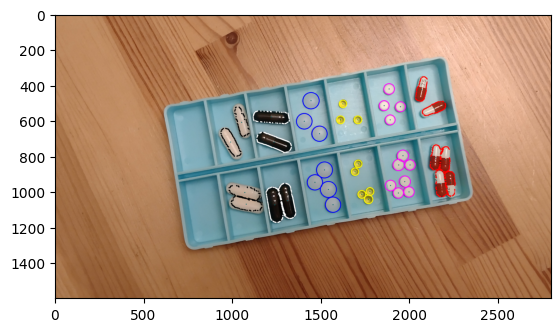

In [22]:
found = detect_objects(calib)
display_objects(calib, found)

### Test

Przetestuj swój algorytm na obrazie testowym `test.png` (lub `test_line.png`, jeśli podejmujesz się detekcji klasy LINE).
Gdzie pojawiają się problemy, skąd się biorą?
Jak można im zaradzić?

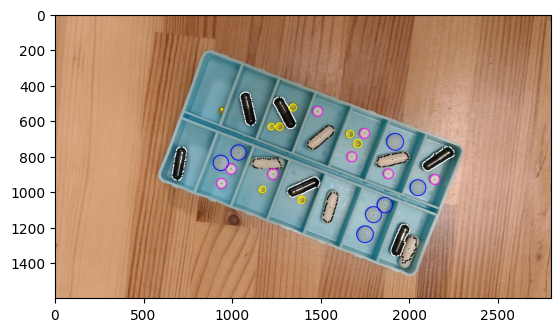

In [23]:
found = detect_objects(test)
display_objects(test, found)

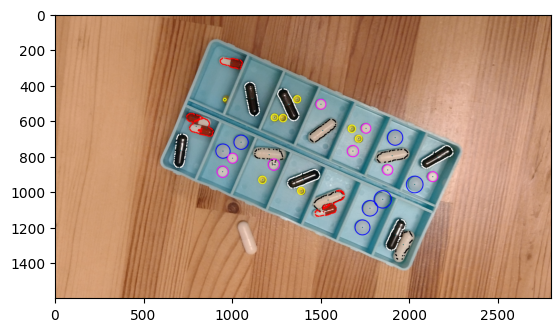

In [24]:
found = detect_objects(line)
display_objects(line, found)

---

### Zadanie dodatkowe - dla chętnych

Cel: zliczenie wystąpień leków w poszczególnych komórkach organizera.

Wykorzystaj transformację Hougha do wykrycia linii oddzielających komórki organizera.
Dowolną poznaną metodą oblicz środki wykrytych obiektów.
Połącz obie informacje by określić zawartość każdej z komórek.

Wynik tej operacji powinien mieć formę struktury logicznej, pozwalającej na odpowiadanie na pytania np. "czy w 3 komórce dolnego rzędu są dwie sztuki `biox`?";
żadne szczegóły implementacyjne tej struktury nie są narzucone.

Jak poprzednio, zacznij od obrazu `calib`, a gotowy algorytm przetestuj na obrazach testowych.

In [25]:
def detect_line(dest_img, probio_pills, carbon_pills, espu_pills, biox_pills):
    dest_img = dest_img.copy()
    PILL_LIST = []
    RED_PART = cv2.threshold(cv2.cvtColor(dest_img, cv2.COLOR_RGB2LAB)[..., 1], 170, 255, cv2.THRESH_BINARY)[1]
    WHITE_PART = cv2.threshold(dest_img[..., 0], 205, 255, cv2.THRESH_BINARY)[1]
    RED_WHITE_MERGE = cv2.bitwise_xor(RED_PART, WHITE_PART)
    WHOLE_PILLS = ~cv2.threshold(cv2.cvtColor(dest_img, cv2.COLOR_RGB2HSV)[..., 0], 20, 179, cv2.THRESH_BINARY)[1]


    for espu in espu_pills:
        cv2.circle(RED_WHITE_MERGE, espu.location[0], espu.location[1], (0, 0, 0), -1)
        cv2.circle(WHOLE_PILLS, espu.location[0], espu.location[1], (0, 0, 0), -1)
    
    for biox in biox_pills:
        cv2.circle(RED_WHITE_MERGE, biox.location[0], biox.location[1], (0, 0, 0), -1)
        cv2.circle(WHOLE_PILLS, biox.location[0], biox.location[1], (0, 0, 0), -1)

    for probio in probio_pills:
        cv2.drawContours(RED_WHITE_MERGE, probio.location[1], -1, (0, 0, 0), cv2.FILLED)
        cv2.drawContours(WHOLE_PILLS, probio.location[1], -1, (0, 0, 0), cv2.FILLED)

    for carbon in carbon_pills:
        cv2.drawContours(RED_WHITE_MERGE, carbon.location[1], -1, (0, 0, 0), cv2.FILLED)
        cv2.drawContours(WHOLE_PILLS, carbon.location[1], -1, (0, 0, 0), cv2.FILLED)

    WHOLE_PILLS = cv2.threshold(WHOLE_PILLS, 160, 179, cv2.THRESH_BINARY)[1]
    _, lbs = cv2.connectedComponents(WHOLE_PILLS, connectivity = 4)
    WHOLE_PILLS[lbs == mode(lbs.flatten())] = 0
    WHOLE_PILLS = cv2.morphologyEx(WHOLE_PILLS, cv2.MORPH_OPEN, np.ones((3, 3), np.uint8), iterations = 2)
    WHOLE_PILLS = cv2.morphologyEx(WHOLE_PILLS, cv2.MORPH_CLOSE, np.ones((3, 3), np.uint8), iterations = 2)

    RED_WHITE_MERGE = cv2.morphologyEx(RED_WHITE_MERGE, cv2.MORPH_CLOSE, np.ones((3, 3), np.uint8), iterations = 3)
    _, labels = cv2.connectedComponents(RED_WHITE_MERGE, connectivity = 4)
    sizes2 =  np.bincount(labels.ravel())
    sizess = sizes2[1:]
    labelss = np.array(list(set(list(labels.flatten())))[1:])
    dct = dict(zip(labelss, sizess))
    filtered_dct = {k: v for k, v in dct.items() if v > 2000}
    RED_WHITE_MERGE[~np.isin(labels, list(filtered_dct.keys()))] = 0

    color_full_image = WHOLE_PILLS.copy()
    _, markers = cv2.connectedComponents(RED_WHITE_MERGE, connectivity= 4)
    cv2.watershed(cv2.merge([color_full_image] * 3), markers)
    color_full_image[markers == -1] = 0
    color_full_image = cv2.erode(color_full_image, kernel = np.ones((3, 3), np.uint8), anchor = (-1, -1), borderType = cv2.BORDER_REPLICATE)
    
    contours, _ = cv2.findContours(color_full_image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    # cv2.drawContours(dest_img, contours, -1, (0, 255, 0), 3)
    for contour in contours:
        M = cv2.moments(contour)
        
        if M['m00'] != 0:
            cx = int(M['m10'] / M['m00'])
            cy = int(M['m01'] / M['m00'])
            center = (cx, cy)
        else:
            center = None
        
        PILL_LIST.append(Pill(PillType.LINE, (center, contour)))
    
    return PILL_LIST

In [26]:
output = calib.copy()
# output = line.copy()
all_circles = []
ketos = []
bioxs = []
espus = []

segment_output = segment_img(cv2.GaussianBlur(cv2.cvtColor(output, cv2.COLOR_RGB2HLS), (21, 21), sigmaX = 0), **PARAMS)
segment_output = extract_object(output, segment_output)
segment_background = output[segment_output != 0] = 0
img_splitted, img_background = split_cells(segment_output)
labels = get_labels(img_background)
flabels = filter_labels(labels, img_splitted)

for label in flabels:
    roi = single_roi(calib, labels, label)
    # roi = single_roi(line, labels, label)
    keto = detect_keto(roi, segment_output)
    biox = detect_biox(roi, segment_output)
    epsu, circles = detect_espu(roi, segment_output)
    all_circles.append(circles)
    ketos = ketos + keto
    bioxs = bioxs + biox
    espus = espus + epsu
all_circles = squeeze_circles(all_circles)
carbon = detect_carbon(segment_output)
probio = detect_probio(segment_output, all_circles)
# lines = detect_line(segment_output, probio, carbon, espus, bioxs)

# probio_background = detect_probio(segment_background, all_circles)
# output = detect_probio(output, all_circles)
pills = list(itertools.chain(probio, carbon, ketos, espus, bioxs))


In [27]:
dest_img = segment_output.copy()
PILL_LIST = []
RED_PART = cv2.threshold(cv2.cvtColor(dest_img, cv2.COLOR_RGB2LAB)[..., 1], 169, 255, cv2.THRESH_BINARY)[1]
WHITE_PART = cv2.threshold(dest_img[..., 0], 200, 255, cv2.THRESH_BINARY)[1]
RED_WHITE_MERGE = cv2.bitwise_xor(RED_PART, WHITE_PART)
WHOLE_PILLS = cv2.cvtColor(dest_img, cv2.COLOR_RGB2HSV)[..., 0]
WHOLE_PILLS = ~cv2.threshold(WHOLE_PILLS, 30, 179, cv2.THRESH_BINARY)[1]
WHOLE_PILLS[WHOLE_PILLS == 76] = 0

for espu in espus:
    cv2.circle(RED_WHITE_MERGE, espu.location[0], espu.location[1], (0, 0, 0), -1)
    cv2.circle(WHOLE_PILLS, espu.location[0], espu.location[1], (0, 0, 0), -1)
    
for biox in bioxs:
    cv2.circle(RED_WHITE_MERGE, biox.location[0], biox.location[1], (0, 0, 0), -1)
    cv2.circle(WHOLE_PILLS, biox.location[0], biox.location[1], (0, 0, 0), -1)

for p in probio:
    cv2.drawContours(RED_WHITE_MERGE, [p.location[1]], -1, (0, 0, 0), cv2.FILLED)
    cv2.drawContours(WHOLE_PILLS, [p.location[1]], -1, (0, 0, 0), cv2.FILLED)

for c in carbon:
    cv2.drawContours(RED_WHITE_MERGE, [c.location[1]], -1, (0, 0, 0), cv2.FILLED)
    cv2.drawContours(WHOLE_PILLS, [c.location[1]], -1, (0, 0, 0), cv2.FILLED)
    
    
_, lbs = cv2.connectedComponents(WHOLE_PILLS, connectivity = 4)
WHOLE_PILLS[lbs == mode(lbs.flatten())] = 0
WHOLE_PILLS = cv2.morphologyEx(WHOLE_PILLS, cv2.MORPH_OPEN, np.ones((3, 3), np.uint8), iterations = 1)
_, labels = cv2.connectedComponents(WHOLE_PILLS, connectivity = 4)
sizes =  np.bincount(labels.ravel())[1:]
labelss = np.array(list(set(list(labels.flatten())))[1:])
dct = dict(zip(labelss, sizes))
filtered_dct = {k: v for k, v in dct.items() if v > 2700}
WHOLE_PILLS[~np.isin(labels, list(filtered_dct.keys()))] = 0


RED_WHITE_MERGE = cv2.morphologyEx(RED_WHITE_MERGE, cv2.MORPH_CLOSE, np.ones((3, 3), np.uint8), iterations = 2)
RED_WHITE_MERGE = cv2.morphologyEx(RED_WHITE_MERGE, cv2.MORPH_OPEN, np.ones((3, 3), np.uint8), iterations = 1)
RED_WHITE_MERGE[WHOLE_PILLS == 0] = 0
_, labels2 = cv2.connectedComponents(RED_WHITE_MERGE, connectivity = 4)
sizes2 =  np.bincount(labels2.ravel())[1:]
labelss2 = np.array(list(set(list(labels2.flatten())))[1:])
dct2 = dict(zip(labelss2, sizes2))
dct2 = dict(sorted(dct2.items(), key=lambda item: item[1], reverse=True))

filtered_dct2 = {k: v for k, v in dct.items() if v > 10}
RED_WHITE_MERGE[~np.isin(labels2, list(filtered_dct2.keys()))] = 0



color_full_image = WHOLE_PILLS.copy()
_, markers = cv2.connectedComponents(RED_WHITE_MERGE, connectivity= 4)
cv2.watershed(cv2.merge([color_full_image] * 3), markers)
color_full_image[markers == -1] = 0
color_full_image = cv2.erode(color_full_image, kernel = np.ones((3, 3), np.uint8), anchor = (-1, -1), borderType = cv2.BORDER_REPLICATE)


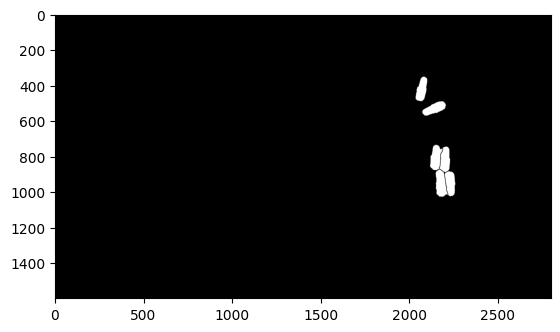

In [28]:
plt.imshow(color_full_image, cmap='gray')

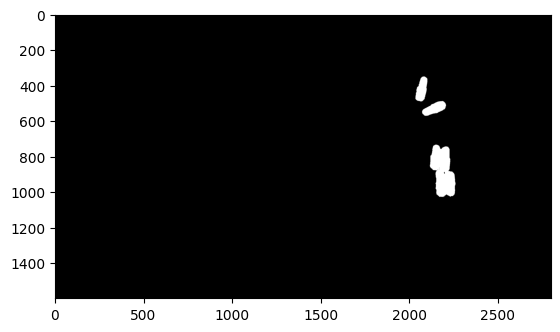

In [29]:
plt.imshow(WHOLE_PILLS, cmap = 'gray')

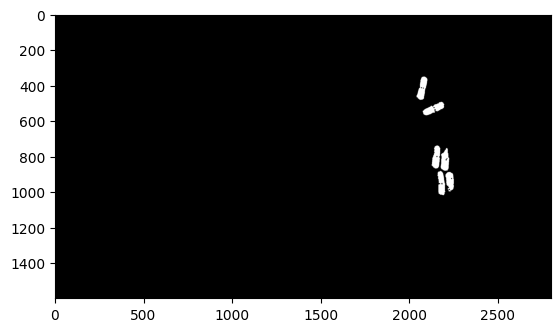

In [30]:
plt.imshow(RED_WHITE_MERGE, cmap = 'gray')